# Custom Effects

This notebook walks you through how to simply add your own custom forces and operators through REBOUNDx.

The first thing you need to decide is whether you want to write a force or an operator. A force function would appropriately update particle accelerations, and REBOUND will call it every timestep in addition to its built-in standard gravitational acceleration function.

By contrast an operator does not calculate accelerations for REBOUND to integrate numerically. Instead it gets called before and/or after each REBOUND timestep, and directly updates particle parameters or particle states (positions, velocities, masses).

This notebook shows how to do both.

# Adding a Custom Force

This example parallels REBOUND's [Forces.ipynb](https://github.com/hannorein/rebound/blob/master/ipython_examples/Forces.ipynb) example, which implements a Python function for calculating the simple Stark force, showing how to add it to REBOUNDx.

The reason you would want to do it this way is if you wanted to use other built-in REBOUNDx effects at the same time (see details at the end of this notebook, and the original Forces.ipynb notebook for context of the force itself--this just shows the method).

In [1]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-6,a=1.)
sim.move_to_com()

We now define our function that updates our particle accelerations.  We also define a flag for whether our force depends on the particle velocities or not, which we'll need to pass to REBOUNDx in order to get accurate behavior.

In [2]:
def starkForce(reb_sim, rebx_force, particles, N):
    # Our function will be passed ctypes pointers. To get Python objects we can access we use: 
    sim = reb_sim.contents
    starkforce = rebx_force.contents
    try:
        # make sure you UPDATE (+=, not =) the accelerations
        # and update the passed particles array, NOT sim.particles 
        particles[1].ax += starkforce.params["c"] 
    except AttributeError:
        raise RuntimeError("Need to set c parameter for custom starkForce routine")

Note that this looks different from an additional force in REBOUND.  In addition to accepting the simulation, it also should take a `rebx_force` Structure, and a `particles` array with the number of particles `N` in it.  

The force structure allows us to store and access parameters. Here we expect the user to set the 'c' parameter determining the perturbation strength. We use a try except block to make sure the user set it.

Now we add REBOUNDx just like we would normally do, and create a new force called 'stark':

In [3]:
import reboundx
rebx = reboundx.Extras(sim)
myforce = rebx.create_force("stark")

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:528: RuntimeWarning: REBOUNDx warning: Force 'stark' not found in REBOUNDx library. Returning custom force. User must initialize force_type enum and update_accelerations function pointer before adding to REBOUNDx

  warnings.warn(msg[1:], RuntimeWarning)


The name 'stark' was not found in the REBOUNDx library, so we get a warning that we need to finish initializing the structure. 

First we need to set the force type:
- "pos": The particle acceleration updates only depend on particle positions (not velocities)
- "vel": Accelerations depend on velocities (can also depend on positions)

Then we set the `update_accelerations` to the function we wrote above, and add our custom force to REBOUNDx:

In [4]:
myforce.force_type = "vel"
myforce.update_accelerations = starkForce

rebx.add_force(myforce)

We wrote our function to read a parameter `c` from our effect, so we need to set it before integrating. The object we get back from `create_force` is a pointer so it doesn't matter if we set parameters before or after calling `rebx.add_force`.

In [5]:
myforce.params["c"] = 0.01

Now we can just integrate as usual. 

In [6]:
import numpy as np
Nout = 1000
es = np.zeros(Nout)
times = np.linspace(0.,100.*2.*np.pi,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    es[i] = sim.particles[1].e 

Comparing the output between this and [Forces.ipynb](https://github.com/hannorein/rebound/blob/master/ipython_examples/Forces.ipynb), it is the same.

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


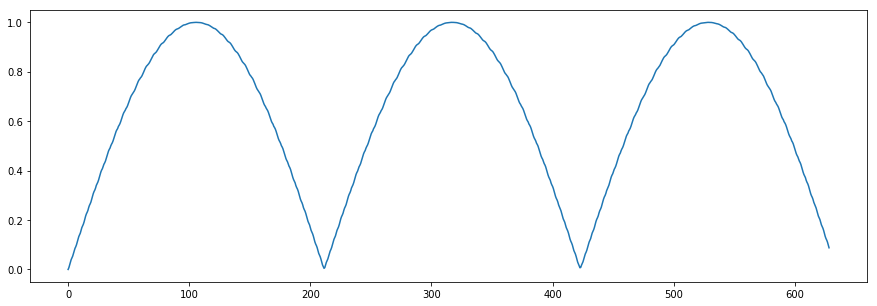

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
plt.xlabel="time"
plt.plot(times, es);

# Adding a Custom Operator

This looks very similar to what we did above, but now this function is executed between integrator timesteps, rather than including a custom force in addition to point source gravity as above.

In [8]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-6,a=1.)
sim.move_to_com()  # Moves to the center of momentum frame

Now we define a simple function that adds mass to `particles[1]` between timesteps.  Note that if this is all you want to do, you probably should use the `modify_mass` effect that's already in REBOUNDx, since that will be substantially faster (since it's doing everything in C and not switching back and forth to call your Python function).  If you haven't, read the description of the custom force above, since all the same points apply here.

In [9]:
def add_mass(reb_sim, rebx_operator, dt):
    sim = reb_sim.contents
    Mdot = 1.e-6 # hard-coded.  Could read a user-set parameter as done above
    sim.particles[1].m += Mdot*dt

We now add REBOUNDx as normal, and create an operator

In [10]:
import reboundx
rebx = reboundx.Extras(sim)
myoperator = rebx.create_operator("massgrowth")

/Users/dtamayo/Documents/workspace/rebound/rebound/simulation.py:528: RuntimeWarning: REBOUNDx warning: Operator 'massgrowth' not found in REBOUNDx library. Returning custom operator. User must initialize operator_type enum and step function pointer before adding to REBOUNDx

  warnings.warn(msg[1:], RuntimeWarning)


Again, the name was not found in the REBOUNDx library, so we're responsible for initializing the Structure.

This time we have to set the operator type:

- "updater": An operator that changes particles states (positions, velocities, masses)
- "recorder": A passive operator that records the state or updates parameters that do not feed back on the dynamics

We also set the `step` function pointer to point to our new function, and add the operator to REBOUNDx:

In [11]:
myoperator.operator_type = "updater"
myoperator.step = add_mass
rebx.add_operator(myoperator)

Now if we integrate and plot the mass of `particles[1]`, we see that our function is getting called, since the mass grows linearly with time.

In [12]:
import numpy as np
Nout = 1000
ms = np.zeros(Nout)
times = np.linspace(0.,10.*2.*np.pi,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    ms[i] = sim.particles[1].m 

/Users/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


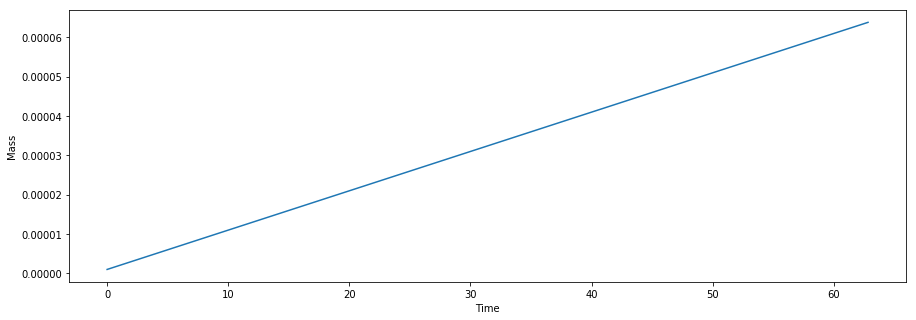

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,5))
ax = plt.subplot(111)
ax.set_xlabel("Time")
ax.set_ylabel("Mass")
ax.plot(times, ms);

# Notes

If you want to mix REBOUNDx forces and operators with custom ones that you write, you need to add your custom ones as shown in this notebook. This is because behind the scenes, REBOUNDx is setting REBOUND's `additional_forces` function pointer--so if you use REBOUNDx to, e.g., include general relativity corrections, and then define a custom force that you set with

`sim.additional_forces = custom_force`

like in REBOUND's [Forces.ipynb](https://github.com/hannorein/rebound/blob/master/ipython_examples/Forces.ipynb) ipython example, then you're overwriting the function pointer and only your force will be included in the simulation.

The above method gives you a quick way to write a python function and run it in a REBOUND simulation and test it out. 
However, it will be slow due to the overhead of calling your python function from C every timestep.
Writing the function in C will be a factor of a few faster, and you could then add it to the REBOUNDx repository so others can use it (and cite your paper!).
Follow instructions in this [page](http://reboundx.readthedocs.org/en/latest/add_effect.html) of the documentation, and feel free to contact us with questions and pull requests.